### Pregunta de Negocio
¿Cómo optimizamos la satisfacción y retención de usuarios mediante recomendaciones musicales personalizadas con base en el estado del ánimo del usuario? 

La motivación detrás de este proyecto surge de la sobrecarga de opciones musicales en la era digital debido al acceso a un vasto catálogo de música, que a veces puede resultar abrumador para los usuarios. En muchas ocasiones, los usuarios se sienten perdidos entre la multitud de opciones, lo que conduce a una experiencia despersonalizada y, en última instancia, a la pérdida de interés. Además, reconocemos la importancia de la emoción y la conexión en la música, ya que sabemos que la música tiene el poder de influir en nuestras emociones y estados de ánimo. Nuestra meta es aprovechar esta capacidad para crear una experiencia musical que no solo sea placentera, sino que también establezca una conexión emocional profunda entre los usuarios y la música que escuchan. 

Los clientes potenciales de este proyecto son los usuarios de servicios de streaming de música que desean compartir su estado de ánimo para recibir recomendaciones más personalizadas. El contexto organizacional donde surge este problema es el ámbito de las empresas que ofrecen este tipo de servicios. Estas plataformas buscan continuamente mejorar su servicio con el fin de satisfacer y retener a la mayor cantidad posible de usuarios. 

 

Para resolver el problema, utilizaremos un algoritmo híbrido de recomendación que combinará filtros colaborativos y basados en contenido para generar una lista de recomendaciones. Por ejemplo, podríamos utilizar la recomendación colaborativa para seleccionar un conjunto inicial de elementos y luego refinar esa lista utilizando el filtrado basado en contenido. Con esto, optimizaremos la satisfacción de los usuarios y aumentaremos su retención. 

### 1. Lectura Dataset

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

df = pd.read_csv("./data/data.csv")
df_gener = pd.read_csv("./data/data_by_genres.csv")
df_gener_arts = pd.read_csv("./data/data_w_genres.csv")

In [4]:
print(df.shape)
df.head()

(170653, 19)


,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


La información recolactada es acerca de diferentes caracteristicas de canciones y artistas para generar un sistema de recomendación para la plataforma Spotify.

Cada registro contiene 19 caracteristicas, las variables son:

0. valence: Una medida de la positividad de una canción. Valores más altos indican canciones más alegres.
1. year: El año de lanzamiento de la canción.
2. acousticness: Una medida de cuán acústica es una canción. Valores cercanos a 1 indican alta acústica.
3. artists: El nombre de los artistas que realizaron la canción.
4. danceability: Una medida de cuán adecuada es una canción para bailar.
5. duration_ms: La duración de la canción en milisegundos.
6. energy: Una medida de la energía de la canción. Valores más altos indican canciones más enérgicas.
7. explicit: Un indicador binario que indica si la canción contiene contenido explícito (1) o no (0).
8. id: Un identificador único para la canción.
9. instrumentalness: Una medida de cuánta presencia de voz o palabras tiene la canción. Valores más altos indican canciones instrumentales.
10. key: La tonalidad de la canción.
11. liveness: Una medida de cuán en vivo suena una grabación. Valores más altos indican que suena más en vivo.
12. loudness: Una medida del volumen general de la canción.
13. mode: La modalidad de la canción (mayor o menor).
14. name: El nombre de la canción.
15. popularity: La popularidad de la canción.
16. release_date: La fecha de lanzamiento de la canción.
17. speechiness: Una medida de cuán "hablada" es una canción en lugar de cantada.
18. tempo: El tempo de la canción (ritmo o velocidad).

Nuestro set de datos tiene un poco más de 170k registros y el total de 19 variables que mencionamos anteriormente

In [5]:
print("Existen {} artistas unicos en nuestro dataset".format(len(df['artists'].unique())))

Existen 34088 artistas unicos en nuestro dataset


## 2. Análisis exploratorio

La idea de realizar el analisis de la información es encontrar patrones y relaciones en los datos que te ayuden a comprender mejor las características de las canciones y cómo se relacionan con las preferencias de los usuarios.

lo realizaremos en las siguientes fases:
1. Análisis Univariable (para cada variable individualmente)
2. Análisis Bivariable (para pares de variables)
3. ingeniería de características

### 1. Análisis Univariable (para cada variable individualmente)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170457 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170633 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170510 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170644 non-null  float64
 7   explicit          14433 non-null   float64
 8   id                170653 non-null  object 
 9   instrumentalness  124073 non-null  float64
 10  key               149053 non-null  float64
 11  liveness          170641 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              120635 non-null  float64
 14  name              170653 non-null  object 
 15  popularity        142761 non-null  float64
 16  release_date      17

Contamos con 9 variables del tipo float o flotante, 6 variables de caracter entero y 4 variables tipo object.

In [14]:
# Contar la cantidad de valores faltantes por variable
missing_values = df.isna().sum()
print(missing_values)

# Contar la cantidad de valores iguales a 0 por variable
zero_values_count = (df == 0).sum()
print(zero_values_count)

valence                196
year                     0
acousticness            20
artists                  0
danceability           143
duration_ms              0
energy                   9
explicit            156220
id                       0
instrumentalness     46580
key                  21600
liveness                12
loudness                 0
mode                 50018
name                     0
popularity           27892
release_date             0
speechiness            143
tempo                  143
dtype: int64
valence             0
year                0
acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
dtype: int64


Se encuentra que el dataset no tiene valores nulos pero si valores faltantes con valores igual a 0, esto no se cumple para todas las variables ya que existen algunas de clase binaria, pero si existen variables como ('tempo' ó 'popularity') que es muy poco probable que tengan valores caracteristicos iguales a 0.

Por esto vamos a calcular el porcentaje de valores faltantes, y posteriormente la inputación de los valores faltantes utilizando knn con un k = 5 y inputación por la moda para los datos categorícos.

In [16]:
def porc_valores_faltantes(df):
    total = df.isnull().sum().sort_values(ascending=False)
    porcentaje = (total / len(df)) * 100
    return pd.concat([total, porcentaje], axis=1, keys=['Total', 'Porcentaje'])

def imputar_numericas_knn(df, n_neighbors=5):  
    columnas_numericas = df.select_dtypes(include=['float64', 'int64']).columns
    df_imputado = df.copy()
    imputador_knn = KNNImputer(n_neighbors=n_neighbors)
    df_imputado[columnas_numericas] = imputador_knn.fit_transform(df[columnas_numericas])
    return df_imputado

def imputar_categorico_por_moda(df):   
    columnas_categoricas = df.select_dtypes(include=['object']).columns
    df_imputado = df.copy()
    for columna in columnas_categoricas:
        moda = df[columna].mode().iloc[0]  # primer valor de la moda
        df_imputado[columna].fillna(moda, inplace=True)
    return df_imputado

In [9]:
import numpy as np

In [17]:
df.replace(0, np.nan, inplace=True)
porc_valores_faltantes(df)

,Total,Porcentaje
explicit,156220,91.542487
mode,50018,29.309769
instrumentalness,46580,27.295154
popularity,27892,16.344278
key,21600,12.657264
valence,196,0.114853
danceability,143,0.083796
speechiness,143,0.083796
tempo,143,0.083796
acousticness,20,0.011720


In [19]:
df = imputar_numericas_knn(df, n_neighbors=3)
df = imputar_categorico_por_moda(df)

In [ ]:
porc_valores_faltantes(df)

,Total,Porcentaje
valence,0,0.0
key,0,0.0
speechiness,0,0.0
release_date,0,0.0
popularity,0,0.0
name,0,0.0
mode,0,0.0
loudness,0,0.0
liveness,0,0.0
instrumentalness,0,0.0


In [ ]:
print("Existen {} artistas unicos en nuestro dataset".format(len(df['artists'].unique())))

Existen 34088 artistas unicos en nuestro dataset


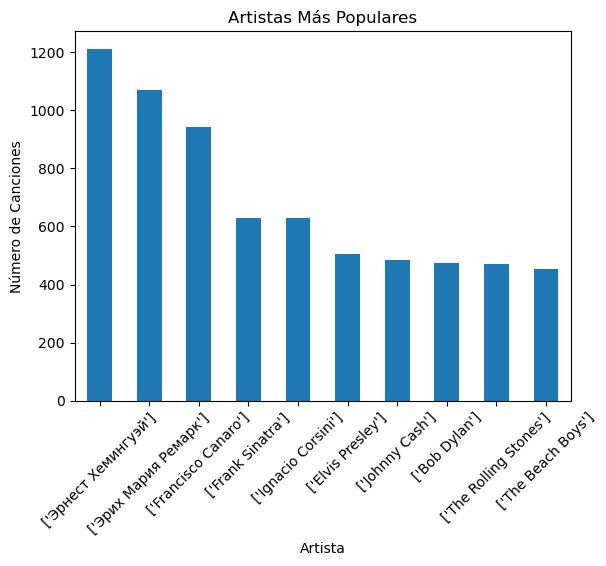

In [ ]:
# Gráfico de Barras de Artistas Populares
top_artists = df['artists'].value_counts().head(10)
top_artists.plot(kind='bar')
plt.xlabel('Artista')
plt.ylabel('Número de Canciones')
plt.title('Artistas Más Populares')
plt.xticks(rotation=45)
plt.show()

Existen más de 34k artistas unicos. En la anterior grafica observamos un top10 de los artistas con mayor cantidad de canciones en el dataset, en donde el artista con más canciones llega a tener más de 1,2k canciones.

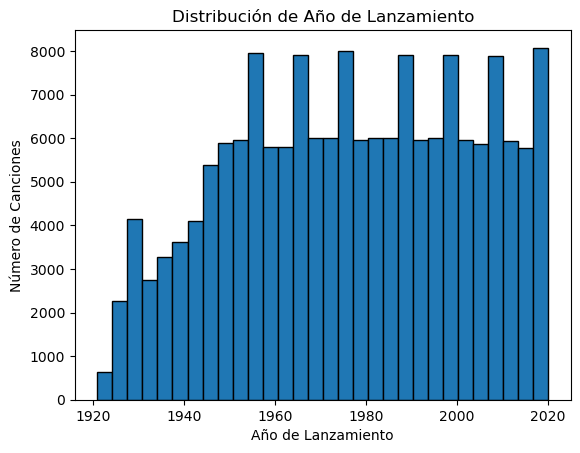

In [ ]:
# Histograma de Año de Lanzamiento
plt.hist(df['year'], bins=30, edgecolor='k')
plt.xlabel('Año de Lanzamiento')
plt.ylabel('Número de Canciones')
plt.title('Distribución de Año de Lanzamiento')
plt.show()

tenemos canciones del año 1920 hasta el año 2020 en donde la cantidad de canciones por decada se distribuye igual apartir del año 1950, con ciertos picos

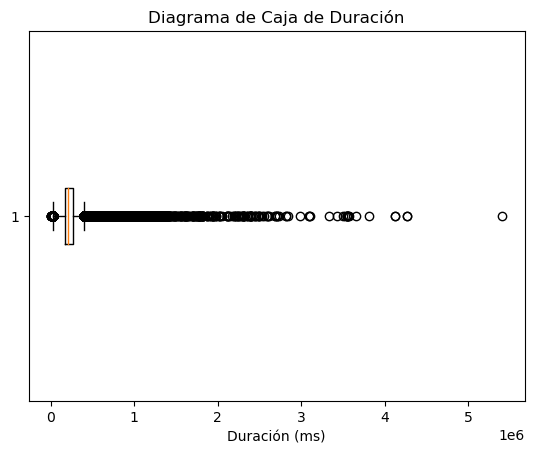

In [ ]:
# Diagrama de Caja de Duración (duration_ms)
plt.boxplot(df['duration_ms'], vert=False)
plt.xlabel('Duración (ms)')
plt.title('Diagrama de Caja de Duración')
plt.show()

la duración media de las canciones es de 3.8 minutos aproximadamente, el 75% de las canciones tiene una duración de 4.3 minutos o menos.

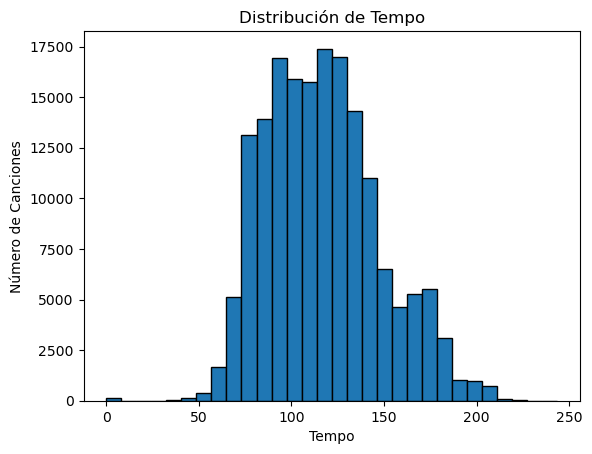

In [ ]:
# Histograma de Tempo
plt.hist(df['tempo'], bins=30, edgecolor='k')
plt.xlabel('Tempo')
plt.ylabel('Número de Canciones')
plt.title('Distribución de Tempo')
plt.show()

la mayor cantidad de las canciones estan a un tempo medio de 116 bpm, en algunos casos canciones llevan ritmos más rapidos hasta los 250 bpm

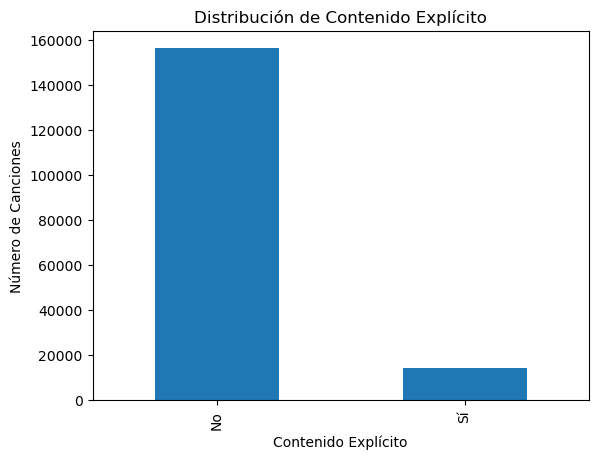

In [ ]:
# Gráfico de Barras de Contenido Explícito
explicit_counts = df['explicit'].value_counts()
explicit_counts.plot(kind='bar')
plt.xlabel('Contenido Explícito')
plt.ylabel('Número de Canciones')
plt.title('Distribución de Contenido Explícito')
plt.xticks([0, 1], ['No', 'Sí'])
plt.show()

Para la variable contenido explicito se tiene un desbalance de más de 85% de los datos inclinados a "No" y solo una pequeña proporción a canciones con contenido explicito. esto puede ser importante en el sistema de recomendación ya que canciones con contenido explicito suelen relacionar temáticas de desorden social, protesta o sexualidad por lo cúal se puede encontrar una relación con algunos generos particulares y tempos de algunas canciones.

In [ ]:
df.describe()

,valence,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
count,170653.000000,170653.000000,170653.000000,170653.000000,1.706530e+05,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000
mean,0.528587,1976.787241,0.502115,0.537396,2.309483e+05,0.482389,0.084575,0.167010,5.199844,0.205839,-11.467990,0.706902,31.431794,0.098393,116.861590
std,0.263171,25.917853,0.376032,0.176138,1.261184e+05,0.267646,0.278249,0.313475,3.515094,0.174805,5.697943,0.455184,21.826615,0.162740,30.708533
min,0.000000,1921.000000,0.000000,0.000000,5.108000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000
25%,0.317000,1956.000000,0.102000,0.415000,1.698270e+05,0.255000,0.000000,0.000000,2.000000,0.098800,-14.615000,0.000000,11.000000,0.034900,93.421000
50%,0.540000,1977.000000,0.516000,0.548000,2.074670e+05,0.471000,0.000000,0.000216,5.000000,0.136000,-10.580000,1.000000,33.000000,0.045000,114.729000
75%,0.747000,1999.000000,0.893000,0.668000,2.624000e+05,0.703000,0.000000,0.102000,8.000000,0.261000,-7.183000,1.000000,48.000000,0.075600,135.537000
max,1.000000,2020.000000,0.996000,0.988000,5.403500e+06,1.000000,1.000000,1.000000,11.000000,1.000000,3.855000,1.000000,100.000000,0.970000,243.507000


**Valence**: La columna "valence" tiene un rango de valores entre 0 y 1, lo que indica la medida de positividad o felicidad en la música. El valor promedio es aproximadamente 0.53, lo que sugiere que la mayoría de las canciones tienden a ser positivas en términos de valencia.

**year**: El año de lanzamiento de las canciones varía desde 1921 hasta 2020. puede resultar interesante comprender tendencias musicales a lo largo del tiempo y considerar la evolución de la música para el sistema de recomendación.

**Acousticness**: La columna "acousticness" mide la proporción de componentes acústicos en las canciones, y varía entre 0 y 1. El valor promedio es aproximadamente 0.50, lo que sugiere que, en promedio, las canciones tienen una mezcla equilibrada entre componentes acústicos y no acústicos.

**Danceability**: tiene un promedio de alrededor de 0.54, lo que indica que en promedio, las canciones tienen un nivel moderado de capacidad para el baile.

**Duration_ms**: La duración de las canciones varía desde unos pocos miles de milisegundos hasta más de 5 millones de milisegundos (aproximadamente 1.5 horas). Esto puede ser útil para el sistema de recomendaciones ya que muchas de ellas son canciones cortas y tan solo una minoria canciones tipo conciertos, live o canciones largas.

**Energy**: tiene un promedio de alrededor de 0.48, lo que sugiere que en promedio, las canciones tienen una energía moderada.

**Explicit**: indica si una canción contiene contenido explícito, con valores binarios (0 para no explícito y 1 para explícito).

**Instrumentalness**: varía desde 0 hasta 1 y mide la proporción de elementos instrumentales en las canciones. El valor promedio es aproximadamente 0.17, lo que indica que en promedio, las canciones tienen una presencia moderada de elementos instrumentales.

**Tempo**: El tempo de las canciones varía desde 0 hasta más de 240 BPM. Esto puede ser útil para identificar la velocidad o ritmo de las canciones.

### 2. Análisis Bivariable (para pares de variables)

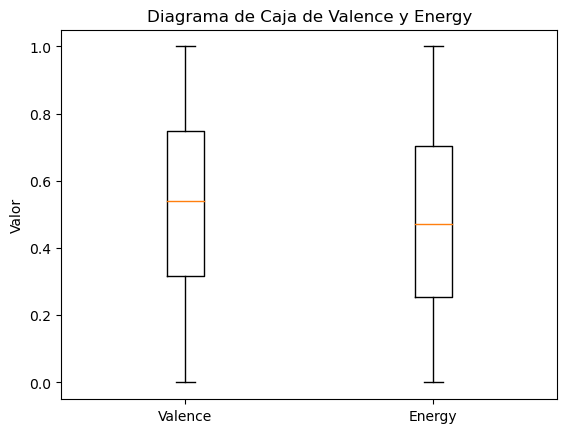

In [ ]:
# Diagrama de Caja de Valence y Energy
plt.boxplot([df['valence'], df['energy']], labels=['Valence', 'Energy'])
plt.ylabel('Valor')
plt.title('Diagrama de Caja de Valence y Energy')
plt.show()

Se encuentra que la **"Energy"**, tiene una distribución muy similar con el **"Valance"** lo cúal indica una variabilidad en la positividad y la energía de las canciones, donde predominan canciones con valores de "Energy" cercanos a 0.5 y de "Valance" cercanos a 0.55

In [ ]:

df_gener.info()
print(f"Se encuentran {len(df_gener['genres'].unique())} generos presentes identificables")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2973 entries, 0 to 2972
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mode              2973 non-null   int64  
 1   genres            2973 non-null   object 
 2   acousticness      2973 non-null   float64
 3   danceability      2973 non-null   float64
 4   duration_ms       2973 non-null   float64
 5   energy            2973 non-null   float64
 6   instrumentalness  2973 non-null   float64
 7   liveness          2973 non-null   float64
 8   loudness          2973 non-null   float64
 9   speechiness       2973 non-null   float64
 10  tempo             2973 non-null   float64
 11  valence           2973 non-null   float64
 12  popularity        2973 non-null   float64
 13  key               2973 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 325.3+ KB
Se encuentran 2973 generos presentes identificables


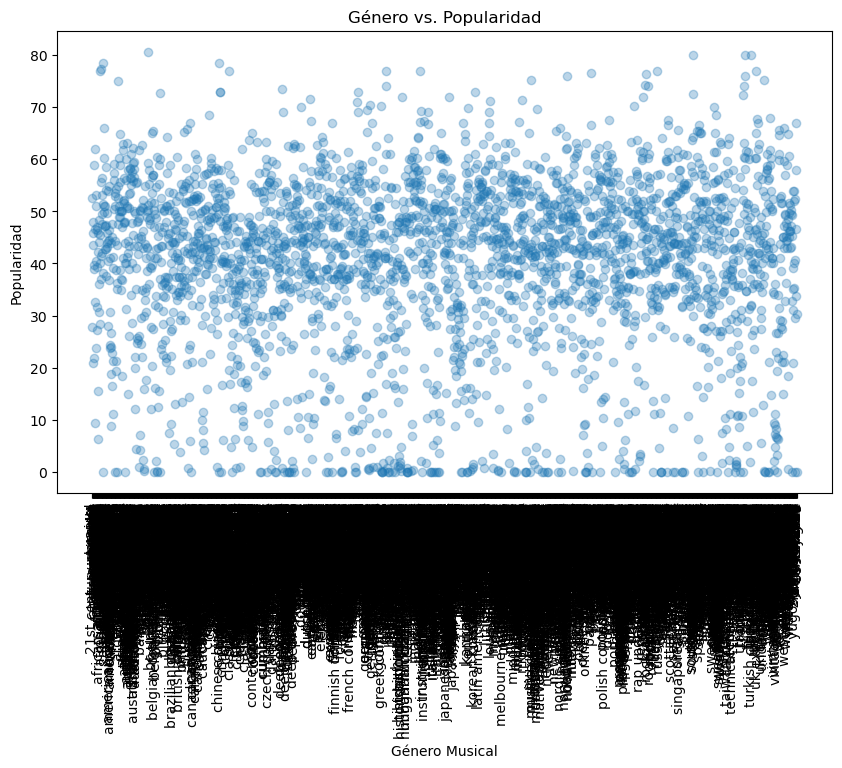

In [ ]:
# Gráfico de dispersión de género vs. popularidad
plt.figure(figsize=(10, 6))
plt.scatter(df_gener['genres'], df_gener['popularity'], alpha=0.3)
plt.xlabel('Género Musical')
plt.ylabel('Popularidad')
plt.title('Género vs. Popularidad')
plt.xticks(rotation=90)
plt.show()

Con el data set "data_by_genres.csv" podemos observar que se encuentran 2973 generos posibles de los cuales podemos generar una marca a nuestros datos de genero dependiendo de las caracteristicas de las canciones y clasificarlas en alguno de estos generos. Esto es importante para los **Filtros Basados en Contenido**, en la anterior grafica podemos visualizar cómo estas características se relacionan con la popularidad de las canciones. Esto puede ayudarte a identificar tendencias en la preferencia de los usuarios. Manejar tantos generos puede ser complicado para algunos modelos por lo tanto podemos optar por tecnicas de agrupamiento.

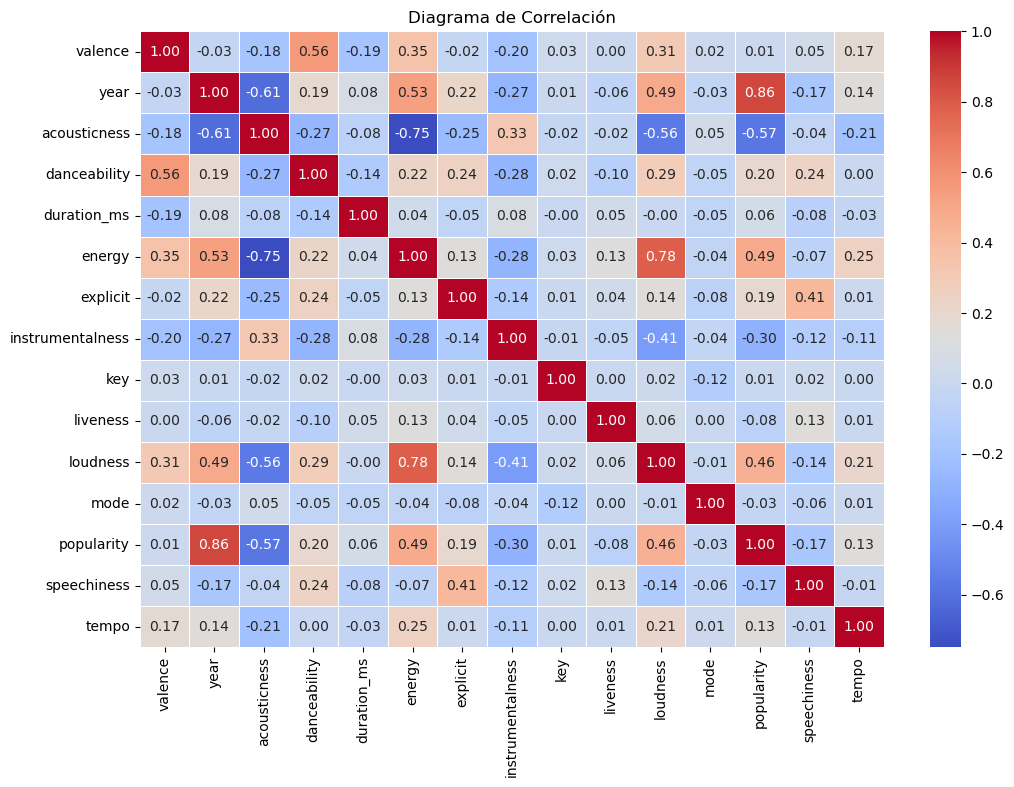

In [ ]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Diagrama de Correlación")
plt.show()

**Valence vs. Danceability**: Existe una correlación positiva notable (0.56) entre la valencia y la danceability de las canciones. Esto sugiere que las canciones con una valencia más alta tienden a ser más bailables, lo que podría ser útil al recomendar música feliz o enérgica.

**Year vs. Popularity**: La columna "year" muestra una correlación positiva moderada (0.86) con la popularidad de las canciones. Esto indica que las canciones más recientes tienden a ser más populares, lo que es consistente con las tendencias en la industria musical.

**Acousticness vs. Energy**: Hay una correlación negativa fuerte (-0.75) entre la "acousticness" y la "energy" de las canciones. Esto sugiere que las canciones más acústicas tienden a tener menos energía. Podría ser útil al recomendar música acústica o enérgica según las preferencias del usuario.

**Loudness vs. Energy**: La "loudness" de las canciones muestra una correlación positiva fuerte (0.78) con la "energy". Esto significa que las canciones más ruidosas tienden a ser más enérgicas, lo que puede ser relevante al recomendar música en función de la energía deseada.

**Popularity vs. Year**: La popularidad de las canciones muestra una correlación positiva (0.46) con el año de lanzamiento. Esto sugiere que, en general, las canciones más recientes tienden a ser más populares, lo que es coherente con las preferencias cambiantes de los usuarios.

**Explicit vs. Speechiness**: Hay una correlación positiva moderada (0.41) entre las canciones explícitas y la "speechiness" (hablado). Esto indica que las canciones explícitas tienden a tener un mayor contenido hablado, lo que puede ser útil al recomendar música con ciertas características líricas.